In [0]:
import numpy as np
import pandas as pd
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_df = pd.read_csv('/content/drive/My Drive/Semester 7/Machine Learning/train.csv',index_col="tripid")
train_df

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,correct
213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,correct
213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,correct


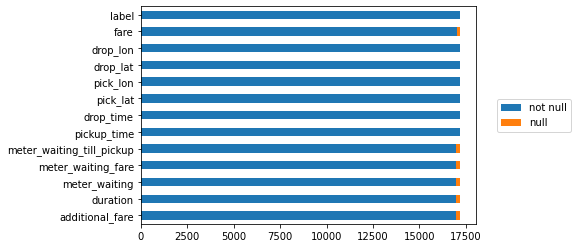

In [5]:
ax = pd.DataFrame({'not null': train_df.count(),
                   'null': train_df.isnull().sum()}).plot.barh(stacked=True)

ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5)
)

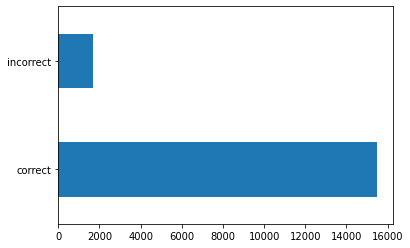

In [6]:
train_df['label'].value_counts().plot.barh()

In [0]:
from sklearn.preprocessing import label_binarize
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

RANDOM_SEED = 42  

In [0]:
labels_raw_df = train_df.loc[:, train_df.columns == 'label']
features_raw_df = train_df.drop(columns=['label'])

In [0]:
def preprocess_labels(input_labels_df):
  labels_df = input_labels_df
  labels_df = pd.DataFrame(label_binarize(labels_df, classes=['incorrrect', 'correct']))
  
  labels_df.columns = labels_df.columns
  labels_df.index = labels_df.index

  return labels_df  

In [0]:
labels_df = preprocess_labels(labels_raw_df)

In [0]:
def preprocess_features(input_features_df):
  features_df = input_features_df.copy()
  numeric_cols = features_df.columns[features_df.dtypes != "object"].values 
  non_numeric_cols = features_df.columns[features_df.dtypes == "object"].values

  #numeric
  #scale features
  scaler = RobustScaler()
  features_df[numeric_cols] = scaler.fit_transform(features_df[numeric_cols])

  #impute missing values
  imputer = KNNImputer()
  features_df[numeric_cols] = imputer.fit_transform(features_df[numeric_cols])

  #date time
  features_df['pickup_time'] = pd.to_datetime(features_df['pickup_time'])
  features_df['drop_time'] = pd.to_datetime(features_df['drop_time'])
  
  #get day of the week
  features_df['pickup_day_of_week'] = features_df['pickup_time'].dt.day_name()
  features_df['drop_day_of_week'] = features_df['drop_time'].dt.day_name()
  
  features_df['pickup_hour_float'] = features_df['pickup_time'].dt.hour + features_df['pickup_time'].dt.minute/60
  features_df['drop_hour_float'] = features_df['drop_time'].dt.hour + features_df['drop_time'].dt.minute/60

  #encode cyclic 24 hours with sin and cos
  features_df['sin_pickup_time'] = np.sin(2*np.pi*features_df.pickup_hour_float/24.)
  features_df['cos_pickup_time'] = np.cos(2*np.pi*features_df.pickup_hour_float/24.)

  features_df['sin_drop_time'] = np.sin(2*np.pi*features_df.drop_hour_float/24.)
  features_df['cos_drop_time'] = np.cos(2*np.pi*features_df.drop_hour_float/24.)

  #get weekday or weekend
  weekenddays = ['Saturday', 'Sunday']

  features_df['pickup_weekday'] = np.where(features_df['pickup_day_of_week'].isin(weekenddays), 0, 1)
  features_df['drop_weekday'] = np.where(features_df['drop_day_of_week'].isin(weekenddays), 0, 1)
  
  features_df = pd.get_dummies(features_df, columns = ['pickup_day_of_week', 'drop_day_of_week'])
  
  features_df = features_df.drop(columns=['pickup_time','drop_time'])
  
  return features_df

In [12]:
features_df = preprocess_features(features_raw_df)
features_df

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_hour_float,drop_hour_float,sin_pickup_time,cos_pickup_time,sin_drop_time,cos_drop_time,pickup_weekday,drop_weekday,pickup_day_of_week_Friday,pickup_day_of_week_Monday,pickup_day_of_week_Saturday,pickup_day_of_week_Sunday,pickup_day_of_week_Thursday,pickup_day_of_week_Tuesday,pickup_day_of_week_Wednesday,drop_day_of_week_Friday,drop_day_of_week_Monday,drop_day_of_week_Saturday,drop_day_of_week_Sunday,drop_day_of_week_Thursday,drop_day_of_week_Tuesday,drop_day_of_week_Wednesday
tripid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
189123628,0.0,-0.139841,-0.210692,-0.008130,-0.076271,-0.289836,0.008121,-0.070827,-0.230791,0.245445,0.333333,0.566667,0.087156,0.996195,0.147809,0.989016,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
189125358,0.0,-0.174104,-0.238994,-0.008130,0.516949,-0.158529,-0.002320,-0.013383,-0.075451,-0.055323,0.933333,1.150000,0.241922,0.970296,0.296542,0.955020,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
189125719,0.0,0.061753,-0.135220,-0.008130,-0.101695,-0.032110,-0.388631,0.113069,0.171983,0.375431,1.133333,1.433333,0.292372,0.956305,0.366501,0.930418,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
189127273,0.0,-0.327888,0.465409,1.084048,-0.042373,0.065148,-0.105568,0.062345,-0.022191,-0.534883,2.450000,2.616667,0.598325,0.801254,0.632705,0.774393,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
189128020,4.0,0.632908,0.519497,0.491612,0.374576,-0.223031,-0.430394,-0.393127,0.331761,0.610957,3.566667,3.850000,0.803857,0.594823,0.845728,0.533615,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,0.0,-0.136653,-0.094340,0.369919,3.203390,2.116109,8.562645,2.052927,8.395007,-0.053621,22.116667,22.350000,-0.473320,0.880891,-0.418660,0.908143,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
213812756,0.0,0.909562,0.959119,-0.008130,-0.288136,-0.047281,-0.545244,0.191276,0.441609,1.535796,23.116667,23.716667,-0.229200,0.973379,-0.074108,0.997250,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
213813930,0.0,-0.594821,-0.358491,-0.008130,0.313559,1.000084,0.016241,1.019937,0.028849,-0.560199,23.350000,23.416667,-0.169350,0.985556,-0.152123,0.988362,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [0]:
test_features_raw_df = pd.read_csv('/content/drive/My Drive/Semester 7/Machine Learning/test.csv',index_col="tripid")
test_features_df = preprocess_features(test_features_raw_df)

In [13]:
features_df.drop_weekday.min()

0

In [0]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

RANDOM_SEED = 4

In [0]:
def f1(y_pred, dtrain):
  print(dtrain)
  y_true = dtrain.get_label()
  score = f1_score(y_true, np.round(y_pred))
  return 'f1_score', score

In [0]:
data_dmatrix = xgb.DMatrix(data=features_df,label=labels_df)

In [0]:
x_train, x_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.2,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [19]:
# fit model to training data
xgbmodel = xgb.XGBClassifier(seed = RANDOM_SEED)
xgbmodel.fit(x_train, y_train, eval_metric=f1)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=4,
              silent=None, subsample=1, verbosity=1)

In [0]:
y_pred = xgbmodel.predict (x_eval)

In [21]:
print('F1 score: {:.6f}'.format(f1_score(y_eval, y_pred)))
print('F1 score macro: {:.6f}'.format(f1_score(y_eval, y_pred, average='macro')))

F1 score: 0.962187
F1 score macro: 0.724738


In [0]:
def modelfit(xgbmodel, x_train, y_train, x_eval, y_eval, test_features_df, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        params = xgbmodel.get_xgb_params()
        dtrain = xgb.DMatrix(x_train, label=y_train)
        cvresult = xgb.cv(params, dtrain, num_boost_round=xgbmodel.get_params()['n_estimators'], 
                          nfold=cv_folds, feval = f1, early_stopping_rounds=early_stopping_rounds, 
                          verbose_eval=False) 
        xgbmodel.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the model on the data
    xgbmodel.fit(x_train, y_train,eval_metric=f1)
        
    #Predict training set:
    y_train_pred = xgbmodel.predict(x_train)
        
    #Print model report:
    print("\nModel Report")
    print('F1 train score: {:.6f}'.format(f1_score(y_train, y_train_pred)))
    print('F1 train score macro: {:.6f}'.format(f1_score(y_train, y_train_pred, average='macro')))
    
    #Predict training set:
    y_pred = xgbmodel.predict(x_eval)
        
    #Print model report:
    print("\nModel Report")
    print('F1 train score: {:.6f}'.format(f1_score(y_eval, y_pred)))
    print('F1 train score macro: {:.6f}'.format(f1_score(y_eval, y_pred, average='macro')))

    #save test predictions
    test_pred = model.predict(test_features_df)

    submission_df = pd.read_csv('/content/drive/My Drive/Semester 7/Machine Learning/sample_submission.csv',index_col="tripid")

    np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)
    
    submission_df["prediction"] = test_pred

    submission_df.to_csv('/content/drive/My Drive/Semester 7/Machine Learning/submission_4.csv', index=True)

    feat_imp = pd.Series(xgbmodel.booster().get_fscore())
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [44]:
#Choose all predictors except target & IDcols
model = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=-1,
 scale_pos_weight=1,
 seed=27)
modelfit(model, x_train, y_train, x_eval, y_eval, test_features_df)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model Report
F1 train score: 0.981664
F1 train score macro: 0.889694

Model Report
F1 train score: 0.963836
F1 train score macro: 0.757309


TypeError: ignored

In [0]:
#use bayesian optimization to chose parameters 
#train model
#save model
#

def write_to_log(data, new_params=False):
    global model_type
    with open(f'flu/{model_type}_log.txt', 'a') as LOG_FILE:
        if new_params:
            LOG_FILE.write('*' * 50)

        for key, item in data.items():
            LOG_FILE.write(f'{key} : {item} \n')

        if len(data) == 1:
            LOG_FILE.write('_' * 50)
            LOG_FILE.write('\n')

        if new_params:
            LOG_FILE.write('*' * 50)


def record_history(data, new_activity=False):
    global model_type
    with open(f'flu/{model_type}_history.txt', 'a') as history:
        if new_activity:
            history.write('*' * 250 + '\n')
        else:
            history.write(str(data) + '\n')


def tree_optimization(eta, gamma, max_depth, subsample, lambda_val, num_parallel_tree):
    global H1N1_train, H1N1_test, FLU_train, FLU_test, best_H1N1, best_FLU, tree_no, model_type, x_final

    booster_params = {
        'eta': eta,
        'gamma': gamma,
        "eval_metric": "auc",
        'max_depth': int(np.around(max_depth)),
        'subsample': subsample,
        'sampling_method': 'gradient_based',
        'lambda': lambda_val,
        'grow_policy': 'lossguide',
        'num_parallel_tree': num_parallel_tree,
        'objective': 'binary:logistic',
        'verbosity': 1,
    }

    results = {}

    print("generating model")
    if model_type == 'H1N1':
        H1N1_model = xgb.train(booster_params, H1N1_train, num_boost_round=100, evals=[(H1N1_test, 'val')],
                               early_stopping_rounds=10, evals_result=results)
        num_iter = H1N1_model.best_iteration + 1
        best_score_H1N1 = H1N1_model.best_score

        if best_score_H1N1 > best_H1N1:
            print(f"Score incresed to {best_score_H1N1} from {best_H1N1}")
            best_H1N1 = best_score_H1N1
            H1N1_model = xgb.train(booster_params, H1N1_train, num_boost_round=num_iter, evals=[(H1N1_test, 'val')],
                                   evals_result=results)
            H1N1_model.save_model(f'logs/H1N1_{tree_no}_AUC_{best_H1N1}.model')
            submission_H1N1 = H1N1_model.predict(x_final)
            savetxt(f'logs/H1N1_{tree_no}_preds.txt', asarray(submission_H1N1), delimiter=',')

        score = best_score_H1N1

    else:
        FLU_model = xgb.train(booster_params, FLU_train, num_boost_round=100, evals=[(FLU_test, 'val')],
                              early_stopping_rounds=10, evals_result=results)
        num_iter = FLU_model.best_iteration + 1
        best_score_FLU = FLU_model.best_score

        if best_score_FLU > best_FLU:
            print(f"Score increased to {best_score_FLU} from {best_FLU}")
            best_FLU = best_score_FLU
            FLU_model = xgb.train(booster_params, FLU_train, num_boost_round=num_iter, evals=[(FLU_test, 'val')],
                                  evals_result=results)
            FLU_model.save_model(f'logs/FLU_{tree_no}_AUC_{best_FLU}.model')
            submission_FLU = FLU_model.predict(x_final)
            savetxt(f'flu/FLU_{tree_no}_preds.txt', asarray(submission_FLU), delimiter=',')

        score = best_score_FLU

    booster_params['ROC'] = score
    record_history(booster_params)
    tree_no += 1
    return score


def use_bayesian_optimization():
    global model_type
    max_file = open(f"max_params_{model_type}.txt", 'w')

    NN_BAYESIAN = BayesianOptimization(
        tree_optimization,
        {
            'eta': (0, 1),
            'gamma': (0, 2),
            'max_depth': (5, 15),
            'subsample': (0, 1),
            'lambda_val': (0, 3),
            'num_parallel_tree': (7, 17)
        })
    NN_BAYESIAN.maximize(init_points=50, n_iter=550, acq='ei', xi=0.0)
    write_to_log(NN_BAYESIAN.max)
    print('Best NN parameters: ', NN_BAYESIAN.max, file=max_file)


best_H1N1 = 0
best_FLU = 0
model_types = ['H1N1', 'FLU']

for model_type in model_types:
    tree_no = 0
    use_bayesian_optimization()
